# **AKARI Far Infrared Data**

### **Download data into CSV file**

See WISE notebook for more information on flux, magnitude, and other definitions

#### Importing AKARI far infrared $(60, 90, 140, and 160)\mu m$ bright sources, totaling about 1.5 million data points
##### Gzip files are streamed in, and the flux densities, ra, and dec are outputted into the file akari_data.csv

In [61]:
import pandas as pd

file_paths = [
    '../Data/akari_data/main_v1.txt',
    '../Data/akari_data/main_v2.txt',
    '../Data/akari_data/suppl_v2.txt'
]

main_path = '../Data/akari_data_filtered.csv'

placeholder_values = [-9.99e+01, -9.999e+02]

# Wavelengths corresponding to flux columns
wavelengths = [65, 90, 140, 160]

# Columns to keep by index from each line
# Indices: 2=ra, 3=dec, 9-12=fluxes, 17-20=flux quality flags
usecols = [2, 3, 9, 10, 11, 12, 17, 18, 19, 20]

column_names = [
    'ra', 'dec',
    'flux65', 'flux90', 'flux140', 'flux160',
    'qflag65', 'qflag90', 'qflag140', 'qflag160'
]

frames = []

for path in file_paths:
    df = pd.read_fwf(path, header=None, usecols=usecols)
    df.columns = column_names

    # Replace placeholders with NaNs
    flux_cols = ['flux65', 'flux90', 'flux140', 'flux160']
    df[flux_cols] = df[flux_cols].replace(placeholder_values, pd.NA)

    # Compute peak flux and its corresponding wavelength
    df['peak_flux'] = df[flux_cols].max(axis=1)
    df['peak_wl'] = df[flux_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(float)

    frames.append(df)

# Combine all the data
full_df = pd.concat(frames, ignore_index=True)

# Save to CSV
full_df.to_csv(main_path, index=False)

# **Analyzing the Data**

## **Filtered Data**

In [34]:
import csv
import pandas as pd

path = '../Data/akari_data_filtered.csv'
cleaned_path = '../Data/akari_data_protostar_candidate.csv'

data = pd.read_csv(path, low_memory=False)

qflag_cols = ['qflag65', 'qflag90', 'qflag140', 'qflag160']
for col in qflag_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')  

peak_wavelength = (((data['peak_wl'].between(89.5, 90.5)) & (data['qflag90']>2)) | ((data['peak_wl']==65.0) & (data['qflag65']>2)))
low_flux = (data['flux160']<3) & (data['flux140']<3)
p_flux = (data['peak_flux']>3) & (data['peak_flux']<30) & (data['flux90']!=999.9)

column_names = [
    'ra', 'dec',
    'flux65', 'flux90', 'flux140', 'flux160',
    'qflag65', 'qflag90', 'qflag140', 'qflag160', 'peak_wl', 'peak_flux'
]

final_cond = peak_wavelength & low_flux & p_flux

data_cleaned = data.loc[final_cond, column_names]
data_cleaned.to_csv(cleaned_path, index=False)


The data is being filtered based on the following parameters: the quality flag being greater than two, the peak wavelength being either 140 or 90, the peak flux being greater than $1Jy$ 

In [37]:
import pandas as pd
import pandasql as ps
from IPython.display import display, HTML

df = pd.read_csv('../Data/akari_data_protostar_candidate.csv')

query = ("SELECT * FROM df WHERE flux140<>'' and qflag140>2 and qflag160>=1 and qflag90>2")

result = ps.sqldf(query, locals())

display(HTML(result.to_html()))

,ra,dec,flux65,flux90,flux140,flux160,qflag65,qflag90,qflag140,qflag160,peak_wl,peak_flux
0,349.48944,59.75747,8.2260,20.080,1.340000,0.662000,3,3,3,1,90.0,20.080
1,197.55661,-62.19426,28.0600,13.180,1.720000,1.240000,3,3,3,1,65.0,28.060
2,209.97327,-60.76530,22.7200,29.480,2.340000,1.270000,1,3,3,1,90.0,29.480
3,211.27484,-60.52637,28.9300,25.260,2.570000,1.140000,3,3,3,1,65.0,28.930
4,201.07593,-61.90813,6.2980,19.370,1.250000,0.451000,1,3,3,1,90.0,19.370
5,311.83443,41.03933,21.8100,18.050,0.618000,1.110000,3,3,3,1,65.0,21.810
6,313.05530,44.18936,12.8700,14.890,2.980000,0.409000,3,3,3,1,90.0,14.890
7,304.06021,39.64849,29.5900,28.080,2.840000,1.180000,3,3,3,1,65.0,29.590
8,229.38893,-58.52399,4.2440,23.100,1.050000,2.330000,1,3,3,1,90.0,23.100
9,306.86591,40.37576,25.3200,28.300,1.640000,0.752000,3,3,3,1,90.0,28.300


## **Galactic Coordinate Calculator**

In [3]:
ra = 8.76450
dec = 60.77644

# number 20

from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
print(c.galactic)

# 4.36508 -9.57422 -> beautiful agn image

<SkyCoord (Galactic): (l, b) in deg
    (120.93272047, -2.03170924)>


## **Spectral Energy Distribution Graph**

Best-fit dust temperature: 19.09 K


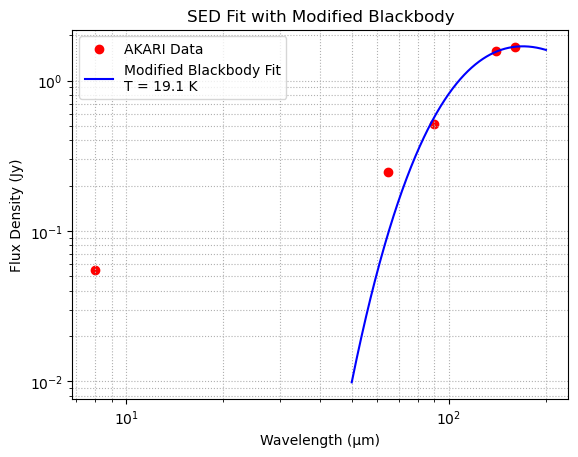

In [29]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.constants import h, c, k_B

wavelengths = [8, 65, 90, 140, 160]  # μm
fluxes = [0.0547,0.247, 0.51, 1.57, 1.67]  # in Jy (Janskys)

# Convert μm to meters
wavelengths_m = np.array(wavelengths) * 1e-6
fluxes = np.array(fluxes)

# Planck function in Jy
def planck_nu(wavelength, T, norm, beta=1.5):
    nu = c.value / wavelength
    B_nu = (2 * h.value * nu**3 / c.value**2) / (np.exp(h.value * nu / (k_B.value * T)) - 1)
    return norm * (wavelength**(-beta)) * B_nu * 1e26  # convert W/m²/Hz to Jy

# Fit the model
popt, pcov = curve_fit(lambda wl, T, norm: planck_nu(wl, T, norm), wavelengths_m, fluxes, p0=[20, 1e-20])

T_fit, norm_fit = popt
print(f"Best-fit dust temperature: {T_fit:.2f} K")

# Plotting
w_plot = np.linspace(50, 200, 500) * 1e-6
f_plot = planck_nu(w_plot, *popt)

plt.scatter(wavelengths, fluxes, label='AKARI Data', color='red')
plt.plot(w_plot * 1e6, f_plot, label=f'Modified Blackbody Fit\nT = {T_fit:.1f} K', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux Density (Jy)")
plt.title("SED Fit with Modified Blackbody")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

# **FITS File Analysis**

## **304.791800 42.439840 -> An unknown star forming region, could contain candidates** (best 1)

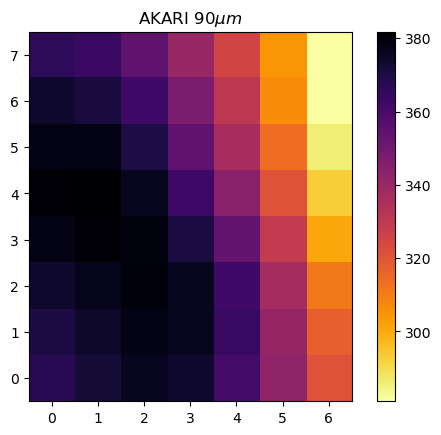

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 105.00 x 120.00 arcsec


In [48]:
from astropy.io import fits
import matplotlib.pyplot as plt

akari90_4 = fits.open("../FITS/unknown, real candidate/fc_304.791800+42.439840_akari_fiswides(90).fits")[0]

plt.imshow(akari90_4.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 90$\mu m$")
plt.show()

cdelt1 = abs(akari90_4.header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(akari90_4.header['CD2_2']) * 3600

width_arcsec = akari90_4.header['NAXIS1'] * cdelt1
height_arcsec = akari90_4.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

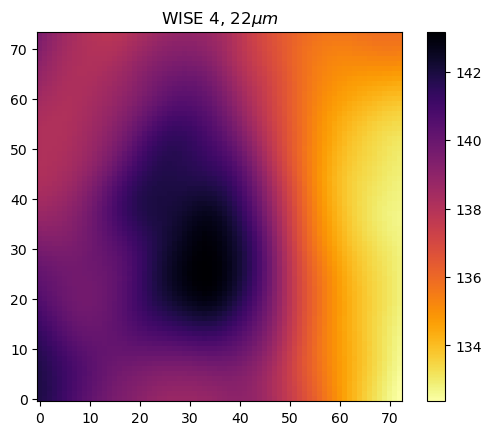

In [63]:
wise4_4 = fits.open("../FITS/unknown, real candidate/fc_304.791800+42.439840_wise_4.fits")[0]

plt.imshow(wise4_4.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("WISE 4, 22$\mu m$")
plt.show()

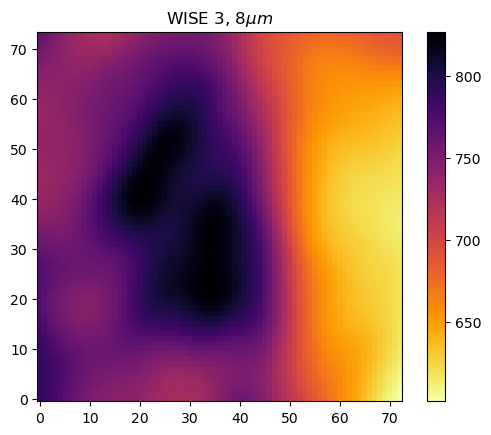

In [64]:
wise3_4 = fits.open("../FITS/unknown, real candidate/fc_304.791800+42.439840_wise_3.fits")[0]

plt.imshow(wise3_4.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("WISE 3, 8$\mu m$")
plt.show()

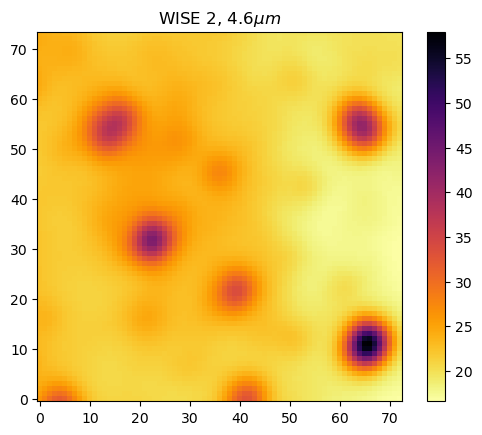

Pixel scale: 1.37 x 1.37 arcsec/pixel
Image size: 100.37 x 101.75 arcsec


In [53]:
wise2_4 = fits.open("../FITS/unknown, real candidate/fc_304.791800+42.439840_wise_2.fits")[0]

plt.imshow(wise2_4.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("WISE 2, 4.6$\mu m$")
plt.show()

cdelt1 = abs(wise2_4.header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(wise2_4.header['CDELT2']) * 3600

width_arcsec = wise2_4.header['NAXIS1'] * cdelt1
height_arcsec = wise2_4.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

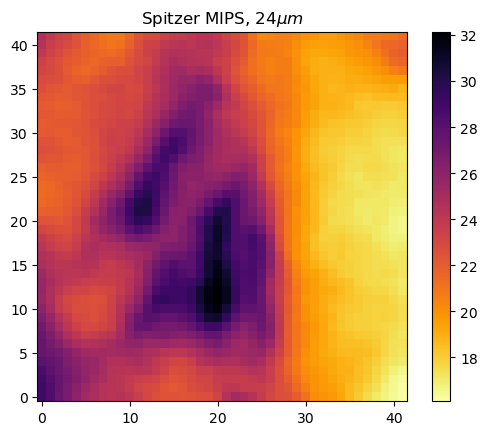

In [62]:
spitzer24_4 = fits.open("../FITS/unknown, real candidate/fc_304.791800+42.439840_spitzer_seipmips24(2.4).fits")[0]

plt.imshow(spitzer24_4.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("Spitzer MIPS, 24$\mu m$")
plt.show()

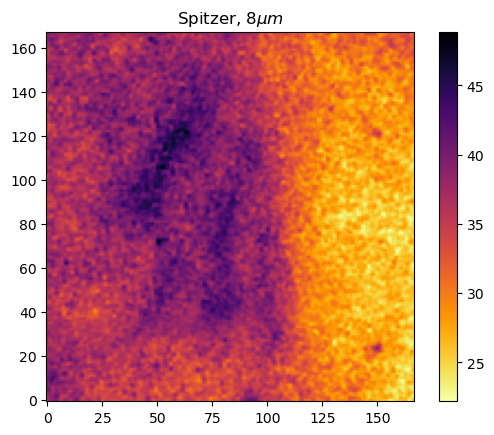

In [61]:
spitzer4_4 = fits.open("../FITS/unknown, real candidate/fc_304.791800+42.439840_spitzer_seipirac4(2.4).fits")[0]

plt.imshow(spitzer4_4.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("Spitzer, 8$\mu m$")
plt.show()

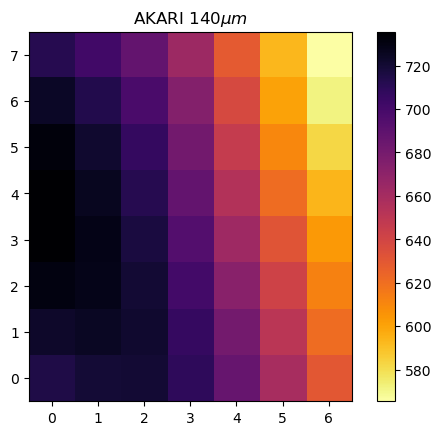

In [65]:
akari140_4 = fits.open("../FITS/unknown, real candidate/fc_304.791800+42.439840_akari_fiswidel(140).fits")[0]

plt.imshow(akari140_4.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 140$\mu m$")
plt.show()

## **348.597540 60.264240 -> Star forming cloud, extremely cold dust**

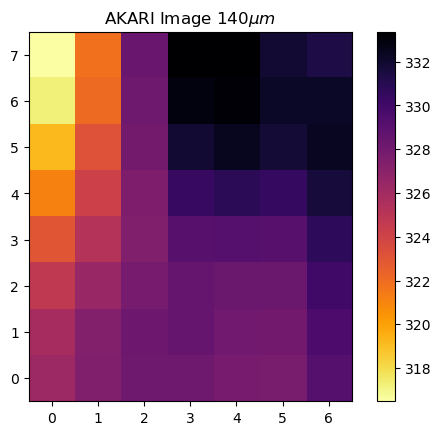

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 105.00 x 120.00 arcsec


In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

fits140 = "../FITS/not visible but in akari-part1/fc_348.597540+60.264240_akari_fiswidel(140).fits"
plt.imshow(fits.open(fits140)[0].data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI Image 140$\mu m$")
plt.show()

cdelt1 = abs(fits.open(fits140)[0].header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(fits.open(fits140)[0].header['CD2_2']) * 3600

width_arcsec = fits.open(fits140)[0].header['NAXIS1'] * cdelt1
height_arcsec = fits.open(fits140)[0].header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

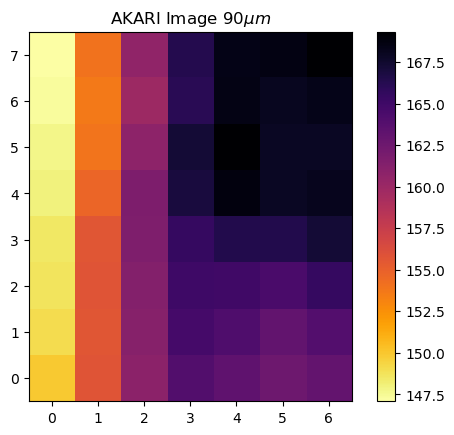

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 105.00 x 120.00 arcsec


In [55]:
fits90 = "../FITS/not visible but in akari-part1/fc_348.597540+60.264240_akari_fiswides(90).fits"
plt.imshow(fits.open(fits90)[0].data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI Image 90$\mu m$")
plt.show()

cdelt1 = abs(fits.open(fits90)[0].header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(fits.open(fits90)[0].header['CD2_2']) * 3600

width_arcsec = fits.open(fits90)[0].header['NAXIS1'] * cdelt1
height_arcsec = fits.open(fits90)[0].header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

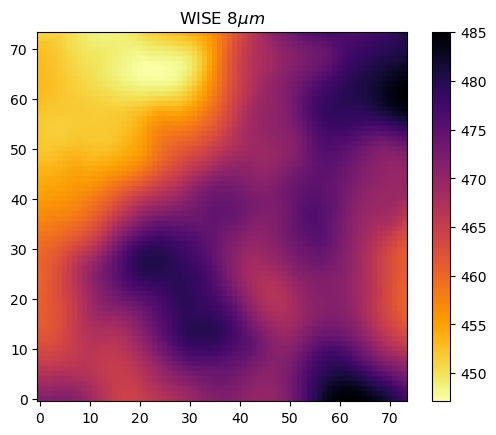

Pixel scale: 1.37 x 1.37 arcsec/pixel
Image size: 101.75 x 101.75 arcsec


In [62]:
wise3 = "../FITS/not visible but in akari-part1/fc_348.597540+60.264240_wise_3.fits"
plt.imshow(fits.open(wise3)[0].data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("WISE 8$\mu m$")
plt.show()

cdelt1 = abs(fits.open(wise3)[0].header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(fits.open(wise3)[0].header['CDELT2']) * 3600

width_arcsec = fits.open(wise3)[0].header['NAXIS1'] * cdelt1
height_arcsec = fits.open(wise3)[0].header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

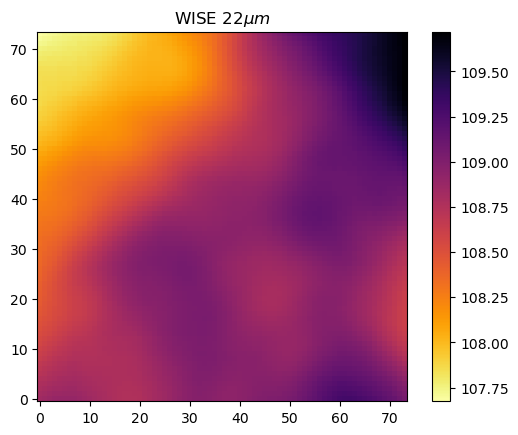

Pixel scale: 1.37 x 1.37 arcsec/pixel
Image size: 101.75 x 101.75 arcsec


In [10]:
wise4_2 = fits.open("../FITS/not visible but in akari-part1/fc_348.597540+60.264240_wise_4.fits")[0]

plt.imshow(wise4_2.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("WISE 22$\mu m$")
plt.show()

cdelt1 = abs(wise4_2.header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(wise4_2.header['CDELT2']) * 3600

width_arcsec = wise4_2.header['NAXIS1'] * cdelt1
height_arcsec = wise4_2.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

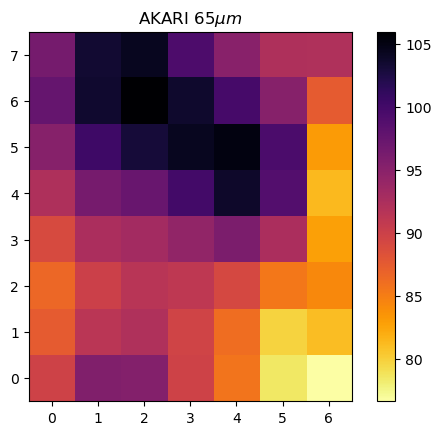

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 105.00 x 120.00 arcsec


In [13]:
akari65_1 = fits.open("../FITS/not visible but in akari-part1/fc_348.597540+60.264240_akari_fisn60(65).fits")[0]

plt.imshow(akari65_1.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 65$\mu m$")
plt.show()

cdelt1 = abs(akari65_1.header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(akari65_1.header['CD2_2']) * 3600

width_arcsec = akari65_1.header['NAXIS1'] * cdelt1
height_arcsec = akari65_1.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

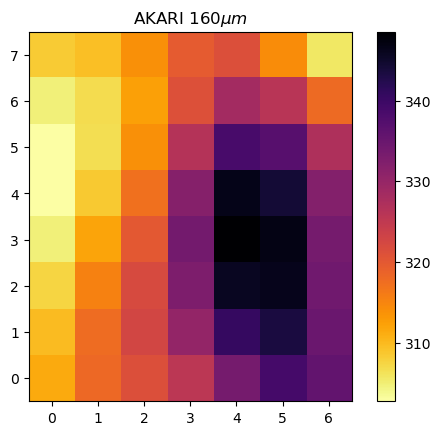

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 105.00 x 120.00 arcsec


In [15]:
akari160_1 = fits.open("../FITS/not visible but in akari-part1/fc_348.597540+60.264240_akari_fisn160(160).fits")[0]

plt.imshow(akari160_1.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 160$\mu m$")
plt.show()

cdelt1 = abs(akari160_1.header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(akari160_1.header['CD2_2']) * 3600

width_arcsec = akari160_1.header['NAXIS1'] * cdelt1
height_arcsec = akari160_1.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

## **233.494840 -56.027020 -> A star forming region, visible candidates in 2MASS**

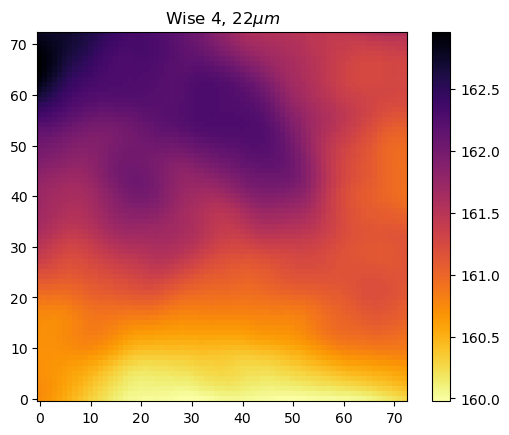

Pixel scale: 1.37 x 1.37 arcsec/pixel
Image size: 100.37 x 100.37 arcsec


In [53]:
from astropy.io import fits
import matplotlib.pyplot as plt

wise4_2 = "../FITS/best candidate-part1/fc_233.494840-56.027020_wise_4.fits"
plt.imshow(fits.open(wise4_2)[0].data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("Wise 4, 22$\mu m$")
plt.show()

cdelt1 = abs(fits.open(wise4_2)[0].header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(fits.open(wise4_2)[0].header['CDELT2']) * 3600

width_arcsec = fits.open(wise4_2)[0].header['NAXIS1'] * cdelt1
height_arcsec = fits.open(wise4_2)[0].header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

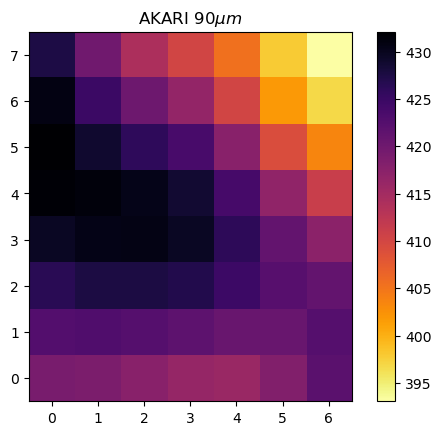

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 105.00 x 120.00 arcsec


In [52]:
akari90_2 = "../FITS/best candidate-part1/fc_233.494840-56.027020_akari_fiswides(90).fits"
plt.imshow(fits.open(akari90_2)[0].data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 90$\mu m$")
plt.show()

cdelt1 = abs(fits.open(akari90_2)[0].header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(fits.open(akari90_2)[0].header['CD2_2']) * 3600

width_arcsec = fits.open(akari90_2)[0].header['NAXIS1'] * cdelt1
height_arcsec = fits.open(akari90_2)[0].header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

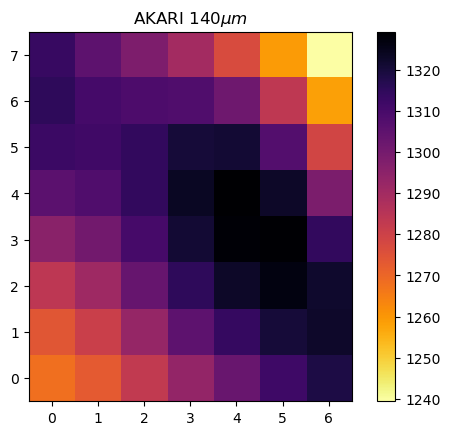

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 105.00 x 120.00 arcsec


In [58]:
akari140_2 = "../FITS/best candidate-part1/fc_233.494840-56.027020_akari_fiswidel(140).fits"
plt.imshow(fits.open(akari140_2)[0].data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 140$\mu m$")
plt.show()

cdelt1 = abs(fits.open(akari140_2)[0].header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(fits.open(akari140_2)[0].header['CD2_2']) * 3600

width_arcsec = fits.open(akari140_2)[0].header['NAXIS1'] * cdelt1
height_arcsec = fits.open(akari140_2)[0].header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

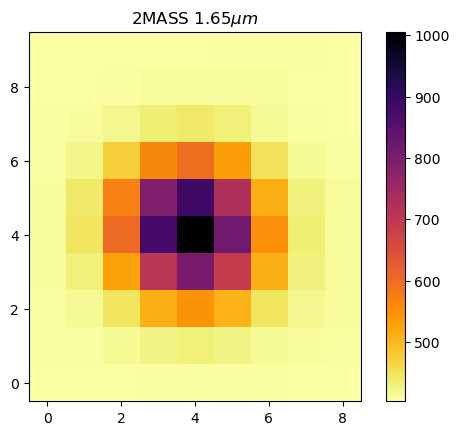

Pixel scale: 1.00 x 1.00 arcsec/pixel
Image size: 101.00 x 101.00 arcsec


In [28]:
mass_1 = fits.open("../FITS/best candidate-part1/fc_233.494840-56.027020_2mass_h.fits")[0]


plt.imshow(mass_1.data[60:70, 63:72], origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("2MASS 1.65$\mu m$")
plt.show()

cdelt1 = abs(mass_1.header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(mass_1.header['CDELT2']) * 3600

width_arcsec = mass_1.header['NAXIS1'] * cdelt1
height_arcsec = mass_1.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

## **4.838770 62.658120** - already known star

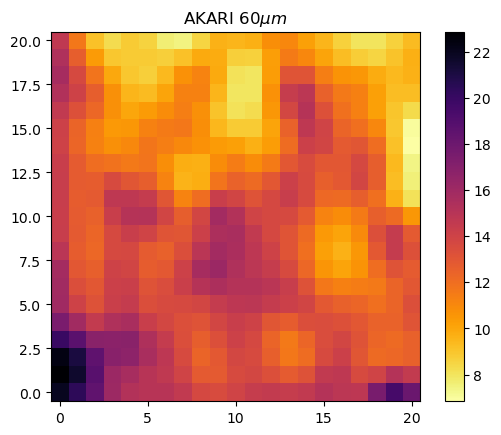

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 315.00 x 315.00 arcsec


In [34]:
from astropy.io import fits
import matplotlib.pyplot as plt

akari65_2 = fits.open("../FITS/could b a source/fc_4.838770+62.658120_akari_fisn60(65).fits")[0]

plt.imshow(akari65_2.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 60$\mu m$")
plt.show()

cdelt1 = abs(akari65_2.header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(akari65_2.header['CD2_2']) * 3600

width_arcsec = akari65_2.header['NAXIS1'] * cdelt1
height_arcsec = akari65_2.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

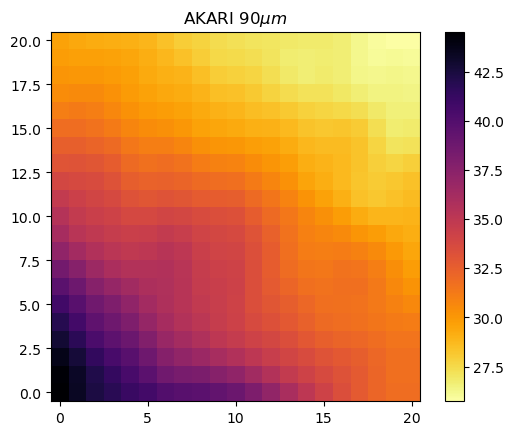

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 315.00 x 315.00 arcsec


In [70]:
akari90_3 = fits.open("../FITS/could b a source/fc_4.838770+62.658120_akari_fiswides(90).fits")[0]

plt.imshow(akari90_3.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 90$\mu m$")
plt.show()

cdelt1 = abs(akari90_3.header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(akari90_3.header['CD2_2']) * 3600

width_arcsec = akari90_3.header['NAXIS1'] * cdelt1
height_arcsec = akari90_3.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

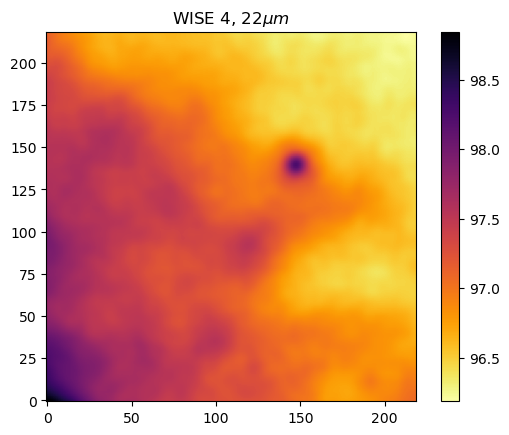

Pixel scale: 1.37 x 1.37 arcsec/pixel
Image size: 301.12 x 301.12 arcsec


In [37]:
wise4_3 = fits.open("../FITS/could b a source/fc_4.838770+62.658120_wise_4.fits")[0]

plt.imshow(wise4_3.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("WISE 4, 22$\mu m$")
plt.show()

cdelt1 = abs(wise4_3.header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(wise4_3.header['CDELT2']) * 3600

width_arcsec = wise4_3.header['NAXIS1'] * cdelt1
height_arcsec = wise4_3.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

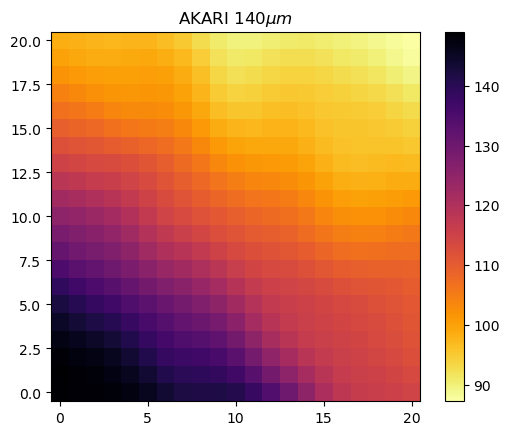

Pixel scale: 15.00 x 15.00 arcsec/pixel
Image size: 315.00 x 315.00 arcsec


In [44]:
akari140_3 = fits.open("../FITS/could b a source/fc_4.838770+62.658120_akari_fiswidel(140).fits")[0]

plt.imshow(akari140_3.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("AKARI 140$\mu m$")
plt.show()

cdelt1 = abs(akari140_3.header['CD1_1']) * 3600  # arcsec/pixel
cdelt2 = abs(akari140_3.header['CD2_2']) * 3600

width_arcsec = akari140_3.header['NAXIS1'] * cdelt1
height_arcsec = akari140_3.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

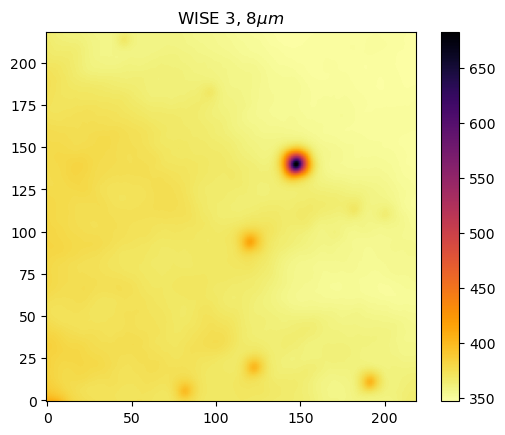

Pixel scale: 1.37 x 1.37 arcsec/pixel
Image size: 301.12 x 301.12 arcsec


In [45]:
wise3_3 = fits.open("../FITS/could b a source/fc_4.838770+62.658120_wise_3.fits")[0]

plt.imshow(wise3_3.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("WISE 3, 8$\mu m$")
plt.show()

cdelt1 = abs(wise3_3.header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(wise3_3.header['CDELT2']) * 3600

width_arcsec = wise3_3.header['NAXIS1'] * cdelt1
height_arcsec = wise3_3.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")

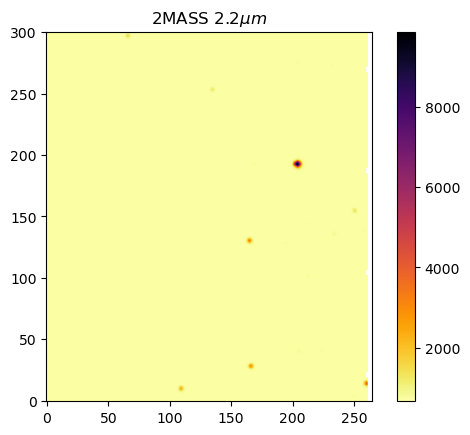

Pixel scale: 1.00 x 1.00 arcsec/pixel
Image size: 265.00 x 301.00 arcsec


In [47]:
massk_3 = fits.open("../FITS/could b a source/fc_4.838770+62.658120_2mass_k.fits")[0]

plt.imshow(massk_3.data, origin='lower', cmap='inferno_r')
plt.colorbar()
plt.title("2MASS 2.2$\mu m$")
plt.show()

cdelt1 = abs(massk_3.header['CDELT1']) * 3600  # arcsec/pixel
cdelt2 = abs(massk_3.header['CDELT2']) * 3600

width_arcsec = massk_3.header['NAXIS1'] * cdelt1
height_arcsec = massk_3.header['NAXIS2'] * cdelt2

print(f"Pixel scale: {cdelt1:.2f} x {cdelt2:.2f} arcsec/pixel")
print(f"Image size: {width_arcsec:.2f} x {height_arcsec:.2f} arcsec")